# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
import plotly.express as px

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

#### Importing time series dataset and Preprocessing it.
1. Load the dataset and set `parse_dates`= `datetime` column and store in a `df` 
   <br>
2. Set index of the dataset with `datetime` column <br> 
   > ` df.index = df['datetime]`
3. 
>  Reindex the dataframe such that the dataframe has a record for  every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset). 

1. Reindex the dataset with `df.reindex(pd.date_range(min(df['datetime']), max(df['datetime']))` and set store it as your `df` <br>
2. Remove the `timestamp` column to fix the duplicated column

In [3]:
df = pd.read_csv('./data/energy.csv', parse_dates=['timestamp'])
df


,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00
...,...,...,...
26299,2014-12-31 19:00:00,"4,012.00",18.00
26300,2014-12-31 20:00:00,"3,856.00",16.67
26301,2014-12-31 21:00:00,"3,671.00",17.00
26302,2014-12-31 22:00:00,"3,499.00",15.33


In [4]:
df.index = df['timestamp']
df = df.reindex(pd.date_range(min(df.index),
                              max(df.index),
                              freq="H"))
df= df.drop(['timestamp','temp'], axis= 1)
df

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
...,...
2014-12-31 19:00:00,"4,012.00"
2014-12-31 20:00:00,"3,856.00"
2014-12-31 21:00:00,"3,671.00"
2014-12-31 22:00:00,"3,499.00"


In [5]:
energy = load_data('./data/')[['load']]
energy

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
...,...
2014-12-31 19:00:00,"4,012.00"
2014-12-31 20:00:00,"3,856.00"
2014-12-31 21:00:00,"3,671.00"
2014-12-31 22:00:00,"3,499.00"


In [6]:
px.line(df, y='load', title='load against time')

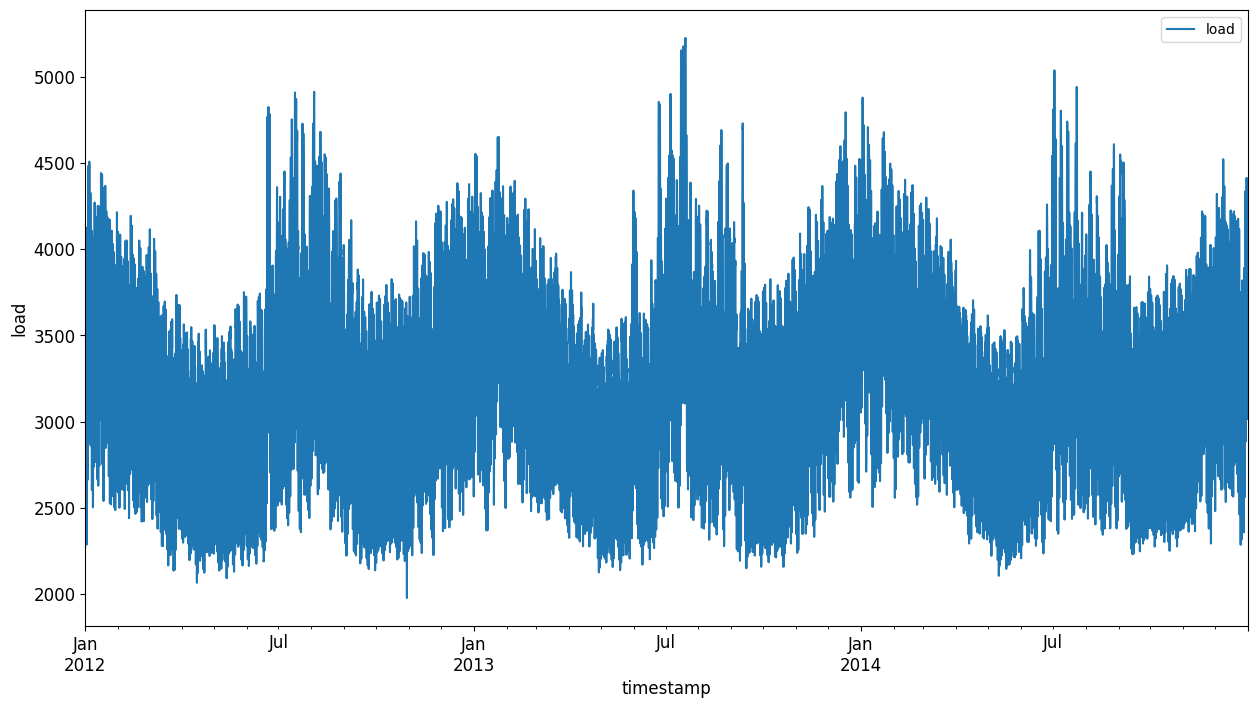

In [7]:
energy.plot(y='load', subplots=True, figsize=(15,8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [8]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

In [9]:
energy.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='h')

In [10]:
# ## split the df into training and testing splits
# #logic 1
# (energy.index < test_start_dt) & (energy.index >= train_start_dt)[['load']]
# ## rename columns
# energy.columns = ['load', 'test']

# #2
# (energy.index )


In [11]:
plot_test_table = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer')


In [12]:
fig2 = px.line(plot_test_table, y=['train', 'test'], title='train-test split')
fig2

In [13]:
plot_test_table # tabular representation of train, test split

,train,test
2014-11-01 00:00:00,"2,514.00",NaN
2014-11-01 01:00:00,"2,434.00",NaN
2014-11-01 02:00:00,"2,390.00",NaN
2014-11-01 03:00:00,"2,382.00",NaN
2014-11-01 04:00:00,"2,419.00",NaN
...,...,...
2014-12-31 19:00:00,NaN,"4,012.00"
2014-12-31 20:00:00,NaN,"3,856.00"
2014-12-31 21:00:00,NaN,"3,671.00"
2014-12-31 22:00:00,NaN,"3,499.00"


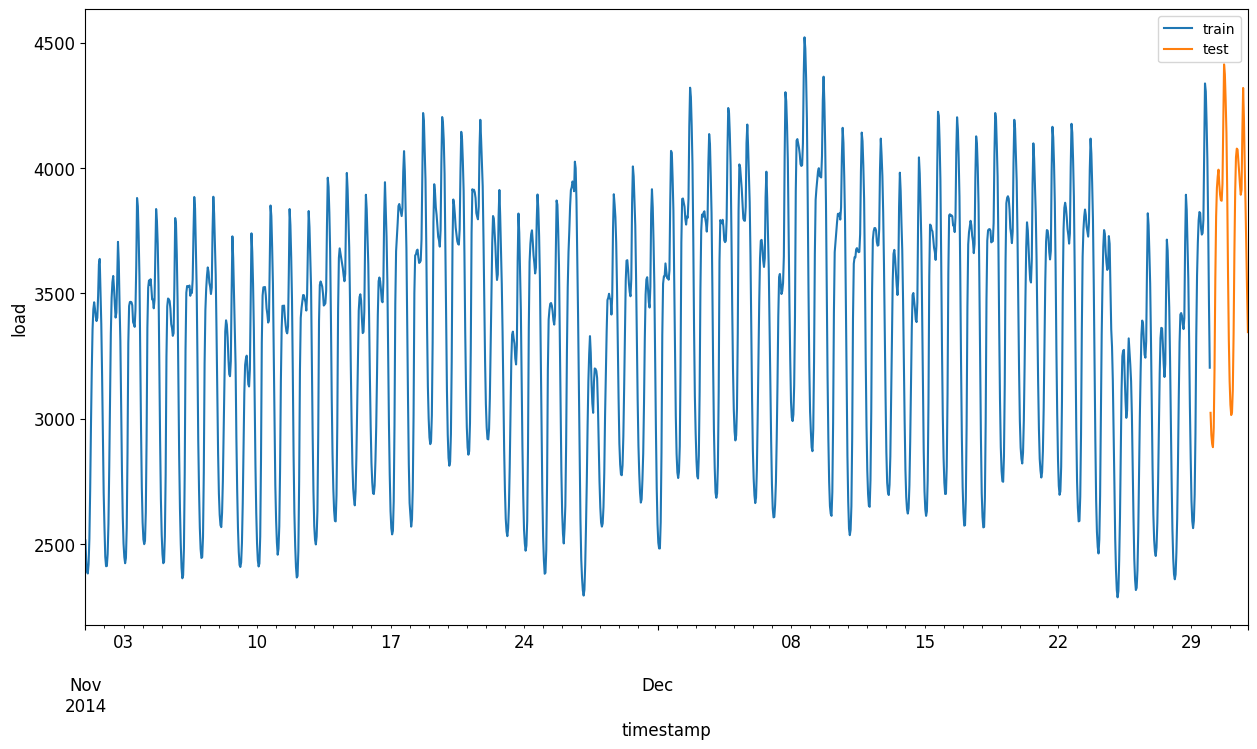

In [14]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [15]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [16]:
train

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"
...,...
2014-12-29 19:00:00,"4,183.00"
2014-12-29 20:00:00,"4,033.00"
2014-12-29 21:00:00,"3,778.00"
2014-12-29 22:00:00,"3,459.00"


In [17]:
train['load'].max()

4521.0

In [18]:
train['load'].idxmax()

#which index does this fall in

Timestamp('2014-12-08 17:00:00')

In [19]:

scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


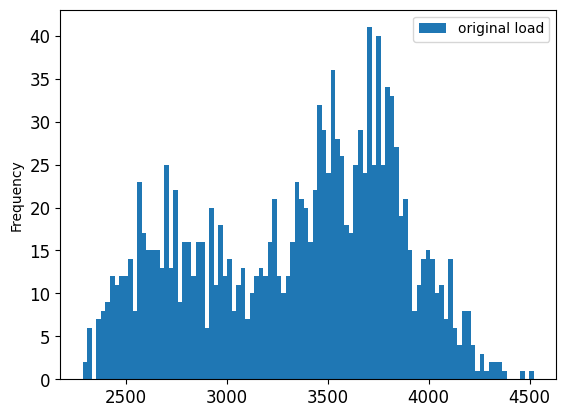

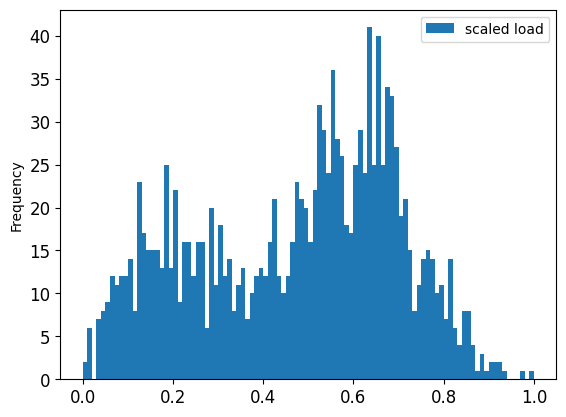

In [20]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [21]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [22]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [23]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.241
Date:                            Fri, 08 Mar 2024   AIC                          -6942.481
Time:                                    17:38:20   BIC                          -6911.054
Sample:                                11-01-2014   HQIC                         -6930.729
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.152      0.000       0.809       0.872
ar.L2         -0.5221      0.034   

In [24]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68
